# Project

### Description
The project aims to generate landscape image based on the emotion and mood analysis of music. The brief progress is to first analyze the mood elicited from the music. Save the analyzed mood data into tokens recognized by a model. By training the model to connect mood data of music with image data, the model can generate corresponding emotional landscape photo.

### Steps
1. Starting from finding datasets. --> Useful_Resources[1 & 3]
2. Retrive music information from the music. Representative mood and emotional music information can be, 
    - Tempo(Librosa frame tempo retrieval), Mode, Loudness/Dynamics(Librosa frame tempo retrieval), Melody, Rhythm... ***As many features as possible.***
3. Use, an example is Random Forest, to find the relation between extracted music information and VA values.
4. Predict VA values from a given song using the trained model.
5. Feed the VA values to train a image genration model (GAN). --> Useful_Resources[2]
6. Evaluate the model.

### Associated Emotion
| Structural Feature | Definition | Associated Emotions |
| -------- | ------- | ------- |
| Tempo | The speed or pace of a musical piece | Fast tempo: excitement, anger. Slow tempo: sadness, serenity. |
| Mode | The type of scale | Major tonality: happiness, joy. Minor tonality: sadness. |
| Loudness(Dynamics) | The physical strength and amplitude of a sound | Intensity, power, or anger |
| Melody | The linear succession of musical tones that the listener perceives as a single entity. Sequence of notes, e.g., C, A, B,... | Complementing harmonies: happiness, relaxation, serenity. Clashing harmonies: excitement, anger, unpleasantness. |
| Rhythm | The regularly recurring pattern or beat of a song | Smooth/consistent rhythm: happiness, peace. Rough/irregular rhythm: amusement, uneasiness. Varied rhythm: joy. |

### Useful Resources
1. [Music Emotion Recognition: Toward new, robust standards in personalized and context-sensitive applications](https://github.com/juansgomez87/datasets_emotion?tab=readme-ov-file)
2. [Emotional Landscape Image Generation Using Generative Adversarial Networks](https://openaccess.thecvf.com/content/ACCV2020/papers/Park_Emotional_Landscape_Image_Generation_Using_Generative_Adversarial_Networks_ACCV_2020_paper.pdf)
3. [Image-Emotion(Arousal and Valence) CGnA10766 Dataset](https://figshare.com/articles/dataset/CGnA10766_Dataset/5383105)

### Challenges
1. ***I can find the dataset from the above linl. However, the dataset already provide the emotions of songs. They are either perceived by the audience, or induced by experiments. The songs are also already classified into emotions in 2D dimention (VA model, valence and arousal) or categories (discrete emotions). What can I do to show that I train a model to using the given song labels and songs?***
    - Given song labels (dimentional or categorical) can be y_train and y_test. Songs are the X_train and X_test. Let's use dimentional data, to better align with specific emotions perceived from landscape photos.
2. ***Music and image are the two source of emotions. Thus, both of them have quantitive values for expressing the emotions. In music part, we know tempo, melody, and etc information can induce an emotion. In the image side, what is that?***
    - Still thinking.
3. ***How to quantify the emotions?***
    - I choose the VA model. V is valence. Valence represents the level of pleasure. The lower value of valence indicates a negative emotion, and the higher value indicates a positive emotion. Arousal is a level of excitement. The smaller the arousal value, the calmer the emotion. The larger the value, the more active the sensation. By aligning VA model values with music information based on the given emotion of the music, we can have a corresponding music to emotion standard.
4. ***Ok. My thought is as follows. Assume I found a dataset of songs, each song is already labelled with VA values. After I extracted the music information using librosa or whatever method from the songs in the dataset, I want to try to match the extracted music information with the VA values. For example, there is a song labelled with VA value of valence equals 3 and arousal equals 4 on the scale of 1 to 9 of 1 being the lowest and 9 being the highest. Then Va values of 3 and 4 can be regarded as quit low mood, maybe sad, on the perspective of me. Then, I extracted some music information from the song. Maybe the tempo is 40 bpm and the melody is C, Eb, and G with certain numbers(I am not that into music, correct me if I have wrong concepts). How do I align or match the VA values and those music informationt together to predict the VA value from a new song? Use random forest to find the connections and for prediction?***
    - The truth, there is no need to limit the music information only on those informatoin that is regarded as the most influencial to the music emotions, such as only consider Tempo instead of other. It is better to have as many features as possible. Like, Tempo (BPM), Chroma Features (12-dimensional vector for pitch classes), MFCCs (20 coefficients capturing timbre), Spectral Contrast (differences in spectral peaks/valleys), Zero-Crossing Rate (noisiness/percussiveness), RMS Energy (loudness/dynamics), Key/Mode (major/minor inferred from chroma or tonal features).
    - Do as following steps. **Normalization**: Scale features (e.g., StandardScaler) if using models sensitive to input range. **Feature Flattening**: Convert multi-dimensional features (e.g., chroma, MFCCs) into a flat vector. Mean? Variance? **Mode Detection**: Use chroma features to infer major/minor mode (e.g., C vs. C minor). **Concatenate VA values**: Add into the dataframe.
    - Use, an example is **Random Forest**, to handles non-linear relationship between VA values and music information.
5. ***How can I evaluate the accuracy between generated images and input music?***
    - I would like to conduct a simple user feedback. Simply ask people to choose VA values of the song and the generated image, and calculate the errors between the two VA values.

### Notes
1. For human nature, this process of thinking of an image representing the emotions we feel can be more natural than transforming an existing image to match the emotions we feel. [Emotional Landscape Image Generation Using
 Generative Adversarial Networks](https://openaccess.thecvf.com/content/ACCV2020/papers/Park_Emotional_Landscape_Image_Generation_Using_Generative_Adversarial_Networks_ACCV_2020_paper.pdf)
2. A common mistake when train a model using supervised learning is feeding the model with data feature names but forget to add feature names to the unseen data when using the trained model for prediction.
3. Version 1 training results: ***Mean Squared Error: 0.8317149672365658*** / ***R^2 Score: 0.4074172312061686***

# Music Information Retrieval
### 1. Music Feature Retrieval

In [ ]:
import pandas as pd
import numpy as np
import librosa
import os

def mir(music_file):
    # Load the audio file
    y, sr = librosa.load(music_file, sr=None)

    # Extract features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13) # 13 DCT coefficients are usually enough for main features representation
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    
    def aggregate(feature_matrix):
        return np.concatenate([np.mean(feature_matrix, axis=1), 
                              np.std(feature_matrix, axis=1)])
    
    features = np.concatenate([
        aggregate(mfccs),
        aggregate(chroma_stft),
        aggregate(spectral_contrast),
        aggregate(zero_crossing_rate),
        aggregate(np.array([tempo]).reshape(-1, 1)) # Reshape tempo to be 2D for aggregation
    ])


    return features

features_list = []
valence_list = []
arousal_list = []
music_name_list = []
music_file_name = 0

print("Starting to extract features...")

train_label_data = pd.read_csv(r"C:\Users\cxoox\Desktop\AIST3110_Project\Music\music_data\static_annotations_averaged_songs_1_2000.csv")
test_label_data = pd.read_csv(r"C:\Users\cxoox\Desktop\AIST3110_Project\Music\music_data\static_annotations_averaged_songs_2000_2058.csv")

    
while music_file_name <= 2058:
    music_path = os.path.join(r"C:\Users\cxoox\Desktop\AIST3110_Project\Music\music_data\audios", str(music_file_name) + ".mp3")
    if os.path.exists(music_path): 
        features = mir(music_path)
        
        # Append features and label to the lists
        features_list.append(features)
        music_name_list.append(music_file_name)
        # Extract valence and arousal values from a csv file of the song_id corresponding to the music
        # Here we assume the csv file has columns 'song_id', 'valence', 'arousal'
        if music_file_name <= 2000:
            valence_list.append(train_label_data[train_label_data['song_id'] == music_file_name][' valence_mean'].values[0]) 
            arousal_list.append(train_label_data[train_label_data['song_id'] == music_file_name][' arousal_mean'].values[0]) 
        else:
            valence_list.append(test_label_data[test_label_data['song_id'] == music_file_name][' valence_mean'].values[0])
            arousal_list.append(test_label_data[test_label_data['song_id'] == music_file_name][' arousal_mean'].values[0]) 
        print(f"Extracted features for {music_file_name}")
        music_file_name += 1
        
    else:
        music_file_name += 1
        

        
# Convert lists to numpy arrays
features_array = np.array(features_list)
valence_array = np.array(valence_list)
arousal_array = np.array(arousal_list)
music_name_array = np.array(music_name_list)

# Create a DataFrame
df = pd.DataFrame(music_name_array, columns=['Music_Name'])
df['Valence'] = valence_array
df['Arousal'] = arousal_array

columns = []
for i in range(13):
    columns.append(f'mfcc_dct{i}_mean')
    columns.append(f'mfcc_dct{i}_std')
for i in range(12):
    columns.append(f'chroma_stft_chord{i}_mean')
    columns.append(f'chroma_stft_chord{i}_std')
for i in range(7):
    columns.append(f'spectral_contrast_frequency{i}_mean')
    columns.append(f'spectral_contrast_frequency{i}_std')
for i in range(1):
    columns.append(f'zero_crossing_rate_frame{i}_mean')
    columns.append(f'zero_crossing_rate_frame{i}_std')
columns.append('tempo_mean')
columns.append('tempo_std')

df = df.join(pd.DataFrame(features_array, columns=columns))

print(df.head())
print(df.shape) # Output: (1000, 70), that is, 1000 songs, 1 label, 1 music name, and 68 features

Starting to extract features...
Extracted features for 2
Extracted features for 3
Extracted features for 4
Extracted features for 5
Extracted features for 7
Extracted features for 8
Extracted features for 10
Extracted features for 12
Extracted features for 13
Extracted features for 17
Extracted features for 18
Extracted features for 19
Extracted features for 20
Extracted features for 21
Extracted features for 22
Extracted features for 24
Extracted features for 25
Extracted features for 31
Extracted features for 32
Extracted features for 35
Extracted features for 37
Extracted features for 39
Extracted features for 40
Extracted features for 41
Extracted features for 42
Extracted features for 43
Extracted features for 44
Extracted features for 45
Extracted features for 46
Extracted features for 47
Extracted features for 48
Extracted features for 49
Extracted features for 50
Extracted features for 51
Extracted features for 52
Extracted features for 53
Extracted features for 54
Extracted fe

In [ ]:
# Save the DataFrame to a CSV file
df.to_csv(r"C:\Users\cxoox\Desktop\AIST3110_Project\Music\music_train_dataset.csv", index=False)

### 2. Preparing Datasets

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the dataset
music_df = pd.read_csv(r"C:\Users\cxoox\Desktop\AIST3110_Project\Music\music_train_dataset.csv")

train_df, test_df = train_test_split(music_df, test_size=0.2, random_state=42)
X_train = train_df.iloc[:, 3:] # Exclude the first three columns (Music_Name, Valence, Arousal)
y_train = train_df[['Valence', 'Arousal']]
X_test = test_df.iloc[:, 3:]
y_test = test_df[['Valence', 'Arousal']]


print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_test.shape}, {y_test.shape}")
print(f"Column names: {X_train.columns}")


Training set shape: (1441, 68), (1441, 2)
Validation set shape: (361, 68), (361, 2)
Column names: Index(['mfcc_dct0_mean', 'mfcc_dct0_std', 'mfcc_dct1_mean', 'mfcc_dct1_std',
       'mfcc_dct2_mean', 'mfcc_dct2_std', 'mfcc_dct3_mean', 'mfcc_dct3_std',
       'mfcc_dct4_mean', 'mfcc_dct4_std', 'mfcc_dct5_mean', 'mfcc_dct5_std',
       'mfcc_dct6_mean', 'mfcc_dct6_std', 'mfcc_dct7_mean', 'mfcc_dct7_std',
       'mfcc_dct8_mean', 'mfcc_dct8_std', 'mfcc_dct9_mean', 'mfcc_dct9_std',
       'mfcc_dct10_mean', 'mfcc_dct10_std', 'mfcc_dct11_mean',
       'mfcc_dct11_std', 'mfcc_dct12_mean', 'mfcc_dct12_std',
       'chroma_stft_chord0_mean', 'chroma_stft_chord0_std',
       'chroma_stft_chord1_mean', 'chroma_stft_chord1_std',
       'chroma_stft_chord2_mean', 'chroma_stft_chord2_std',
       'chroma_stft_chord3_mean', 'chroma_stft_chord3_std',
       'chroma_stft_chord4_mean', 'chroma_stft_chord4_std',
       'chroma_stft_chord5_mean', 'chroma_stft_chord5_std',
       'chroma_stft_chord6_mean'

### 3. Train the Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from joblib import dump

model = RandomForestRegressor(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)

# Save the trained model to a file
dump(model, r"C:\Users\cxoox\Desktop\AIST3110_Project\Music\music_model.joblib")
print("Model saved successfully!")

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)


Model saved successfully!
Mean Squared Error: 0.8317149672365658
R^2 Score: 0.4074172312061686


In [ ]:
features = mir(r"C:\Users\cxoox\Downloads\happy-333069.mp3")
features = np.array(features).reshape(1, -1)
predicted_valence, predicted_arousal = model.predict(features)[0]
print(f"Predicted Valence: {predicted_valence}, Predicted Arousal: {predicted_arousal}")

### 4. Result Plotting

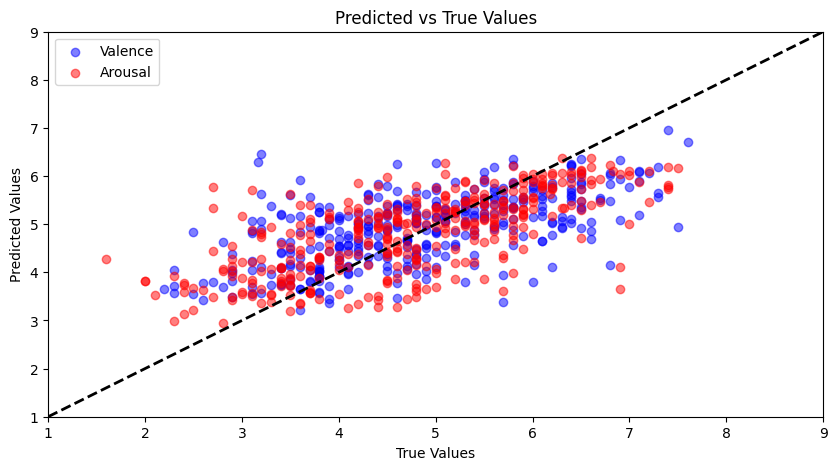

In [ ]:
import matplotlib.pyplot as plt

# Plotting the results, on the scale of 1 to 9
plt.figure(figsize=(10, 5))
plt.scatter(y_test['Valence'], y_pred[:, 0], label='Valence', color='blue', alpha=0.5)
plt.scatter(y_test['Arousal'], y_pred[:, 1], label='Arousal', color='red', alpha=0.5)
plt.plot([1, 9], [1, 9], 'k--', lw=2) # Diagonal line
plt.xlim(1, 9)
plt.ylim(1, 9)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values')
plt.legend()
plt.show()

# Plot the feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features_names = X_train.columns[indices]
plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), features_names, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()